In [1]:
#! pip install icecream
#! pip install torch
#! pip install easydict
#! pip install pandas
#! pip install matplotlib
#! pip install sklearn

In [2]:
import pandas as pd
import time
import numpy as np
import datetime
from icecream import ic

import argparse
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import easydict

In [3]:
# Positional-encoding **********************************************

def positional_encoding(Data):

    df = pd.read_csv(Data)
        
    timestamps = [ts.split('+')[0] for ts in  df['timestamp']]
    timestamps_day = np.array([float(datetime.datetime.strptime(t, '%Y-%m-%d').day) for t in timestamps])
    timestamps_month = np.array([float(datetime.datetime.strptime(t, '%Y-%m-%d').month) for t in timestamps])

    days_in_month = 30
    month_in_year = 12

    df['sin_day'] = np.sin(2*np.pi*timestamps_day/days_in_month)
    df['cos_day'] = np.cos(2*np.pi*timestamps_day/days_in_month)
    df['sin_month'] = np.sin(2*np.pi*timestamps_month/month_in_year)
    df['cos_month'] = np.cos(2*np.pi*timestamps_month/month_in_year)

    return df

train_dataset = positional_encoding('Data/MV_train_raw.csv')
test_dataset = positional_encoding('Data/MV_test_raw.csv')

train_dataset.to_csv(r'Data/MV_train_dataset.csv', index=False)
test_dataset.to_csv(r'Data/MV_test_dataset.csv', index=False)

In [4]:
# helpers*******************************************

import os, shutil

# save train or validation loss
def log_loss(loss_val : float, path_to_save_loss : str, train : bool = True):
    if train:
        file_name = "train_loss.txt"
    else:
        file_name = "val_loss.txt"

    path_to_file = path_to_save_loss+file_name
    os.makedirs(os.path.dirname(path_to_file), exist_ok=True)
    with open(path_to_file, "a") as f:
        f.write(str(loss_val)+"\n")
        f.close()

# Exponential Moving Average, https://en.wikipedia.org/wiki/Moving_average
def EMA(values, alpha=0.1):
    ema_values = [values[0]]
    for idx, item in enumerate(values[1:]):
        ema_values.append(alpha*item + (1-alpha)*ema_values[idx])
    return ema_values

# Remove all files from previous executions and re-run the model.
def clean_directory():

    if os.path.exists('save_loss'):
        shutil.rmtree('save_loss')
    if os.path.exists('save_model'): 
        shutil.rmtree('save_model')
    if os.path.exists('save_predictions'): 
        shutil.rmtree('save_predictions')
    os.mkdir("save_loss")
    os.mkdir("save_model")
    os.mkdir("save_predictions")

In [5]:
# Plots

import matplotlib.pyplot as plt
from icecream import ic 
import numpy as np
import torch

def plot_loss(path_to_save, train=True):
    plt.rcParams.update({'font.size': 10})
    with open(path_to_save + "/train_loss.txt", 'r') as f:
        loss_list = [float(line) for line in f.readlines()]
    if train:
        title = "Train"
    else:
        title = "Validation"
    EMA_loss = EMA(loss_list)
    plt.plot(loss_list, label = "loss")
    plt.plot(EMA_loss, label="EMA loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(title+"_loss")
    plt.savefig(path_to_save+f"/{title}.png")
    plt.close()

def plot_prediction(title, path_to_save, src, tgt, prediction, index_in, index_tar):

    idx_scr = index_in[0, 1:].tolist()
    idx_tgt = index_tar[0].tolist()
    idx_pred = [i for i in range(idx_scr[0] +1, idx_tgt[-1])] #t2 - t61

    plt.figure(figsize=(15,6))
    plt.rcParams.update({"font.size" : 16})

    # connect with last elemenet in src
    # tgt = np.append(src[-1], tgt.flatten())
    # prediction = np.append(src[-1], prediction.flatten())
    #print(idx_scr.shape)
    #print(idx_tgt.shape)
    #print(src.shape)
    #print(tgt.shape)
    # plotting
    plt.plot(idx_scr[1:], src[1:], '-', color = 'blue', label = 'Input', linewidth=2)
    plt.plot(idx_tgt[:-1], tgt[:-1], '-', color = 'indigo', label = 'Target', linewidth=2)
    plt.plot(idx_pred, prediction,'--', color = 'limegreen', label = 'Forecast', linewidth=2)

    #formatting
    plt.grid(b=True, which='major', linestyle = 'solid')
    plt.minorticks_on()
    plt.grid(b=True, which='minor', linestyle = 'dashed', alpha=0.5)
    plt.xlabel("Time Elapsed")
    plt.ylabel("Price ($/lb)")
    plt.legend()
    plt.title("Price Forecast") 

    # save
    plt.savefig(path_to_save+f"Prediction_{title}.png")
    plt.close()
    
def plot_prediction_2(title, path_to_save, forecasts, targets):
    
    idx= [i for i in range(1,len(targets)+1)] 
    
    plt.figure(figsize=(10,6))
    plt.rcParams.update({"font.size" : 16})
    
    plt.plot(idx,targets , '-', color = 'blue', label = 'Actual Value', linewidth=2)
    plt.plot(idx,forecasts , 'o-.', color = 'red', label = 'Forecasts', linewidth=2)

    #formatting
    #plt.grid(b=True, which='major', linestyle = 'solid')
    plt.minorticks_on()
    #plt.grid(b=True, which='minor', linestyle = 'dashed', alpha=0.5)
    plt.xlabel("Samples")
    plt.ylabel("Price ($/lb)")
    plt.legend()
    plt.title(f"Price Forecast- {title} steps ahead") 

    # save
    plt.savefig(path_to_save+f"Prediction_{title}.png")
    plt.close()    



def plot_training(epoch, path_to_save, src, prediction, index_in, index_tar):

    # idx_scr = index_in.tolist()[0]
    # idx_tar = index_tar.tolist()[0]
    # idx_pred = idx_scr.append(idx_tar.append([idx_tar[-1] + 1]))

    idx_scr = [i for i in range(len(src))]
    idx_pred = [i for i in range(1, len(prediction)+1)]

    plt.figure(figsize=(15,6))
    plt.rcParams.update({"font.size" : 18})
    plt.grid(b=True, which='major', linestyle = '-')
    plt.grid(b=True, which='minor', linestyle = '--', alpha=0.5)
    plt.minorticks_on()

    plt.plot(idx_scr, src, 'o-.', color = 'blue', label = 'input sequence', linewidth=1)
    plt.plot(idx_pred, prediction, 'o-.', color = 'limegreen', label = 'prediction sequence', linewidth=1)

    plt.title("Training with sampling"+ ", Epoch " + str(epoch))
    
    plt.xlabel("Time Elapsed")
    plt.ylabel("Price")
    plt.legend()
    plt.savefig(path_to_save+f"/Epoch_{str(epoch)}.png")
    plt.close()

def plot_training_3(epoch, path_to_save, src, sampled_src, prediction, index_in, index_tar):

    # idx_scr = index_in.tolist()[0]
    # idx_tar = index_tar.tolist()[0]
    # idx_pred = idx_scr.append(idx_tar.append([idx_tar[-1] + 1]))

    idx_scr = [i for i in range(len(src))]
    idx_pred = [i for i in range(1, len(prediction)+1)]
    idx_sampled_src = [i for i in range(len(sampled_src))]

    plt.figure(figsize=(15,6))
    plt.rcParams.update({"font.size" : 18})
    plt.grid(b=True, which='major', linestyle = '-')
    plt.grid(b=True, which='minor', linestyle = '--', alpha=0.5)
    plt.minorticks_on()

    ## REMOVE DROPOUT FOR THIS PLOT TO APPEAR AS EXPECTED !! DROPOUT INTERFERES WITH HOW THE SAMPLED SOURCES ARE PLOTTED
    plt.plot(idx_sampled_src, sampled_src, 'o-.', color='red', label = 'sampled source', linewidth=1, markersize=10)
    plt.plot(idx_scr, src, 'o-.', color = 'blue', label = 'input sequence', linewidth=1)
    plt.plot(idx_pred, prediction, 'o-.', color = 'limegreen', label = 'prediction sequence', linewidth=1)
    plt.title("Training with sampling"+ ", Epoch " + str(epoch))
    plt.xlabel("Time Elapsed")
    plt.ylabel("Price ($/lb)")
    plt.legend()
    plt.savefig(path_to_save+f"/Epoch_{str(epoch)}.png")
    plt.close()

In [6]:
# Data loader

import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import os
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
from joblib import dump
from icecream import ic

class MakeDataset(Dataset):

    def __init__(self, csv_name, root_dir, training_length, forecast_window):
        """
        Args:
            csv_file (string): Path to the csv file.
            root_dir (string): Directory
        """
        
        # load raw data file
        csv_file = os.path.join(root_dir, csv_name)
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = MinMaxScaler()
        self.T = training_length
        self.S = forecast_window

    def __len__(self):
        #return number of datasets to get in the getitem step
        return len([1]) 
    
    # Will pull an index between 0 and __len__. 
    def __getitem__(self, idx):
        
        
        idx = idx+1

        # np.random.seed(0)

        start = np.random.randint(0, len(self.df) - self.T - self.S) 
        index_in = torch.tensor([i for i in range(start, start+self.T)])
        index_tar = torch.tensor([i for i in range(start + self.T, start + self.T + self.S)])
        m_input = torch.tensor(self.df[["price", "yield", "sin_day", "cos_day", "sin_month", "cos_month"]][start : start + self.T].values)
        target = torch.tensor(self.df[["price", "yield", "sin_day", "cos_day", "sin_month", "cos_month"]][start + self.T : start + self.T + self.S].values)

        # scalar is fit only to the input, to avoid the scaled values "leaking" information about the target range.
        # scalar is fit only for price, as the timestamps are already scaled
        # scalar input/output of shape: [n_samples, n_features].
        
        scaler_yield=self.transform
        scaler_yield.fit(m_input[:,1].unsqueeze(-1))
        m_input[:,1] = torch.tensor(scaler_yield.transform(m_input[:,1].unsqueeze(-1)).squeeze(-1))
        target[:,1] = torch.tensor(scaler_yield.transform(target[:,1].unsqueeze(-1)).squeeze(-1))
        
        scaler = self.transform
        scaler.fit(m_input[:,0].unsqueeze(-1))
        m_input[:,0] = torch.tensor(scaler.transform(m_input[:,0].unsqueeze(-1)).squeeze(-1))
        target[:,0] = torch.tensor(scaler.transform(target[:,0].unsqueeze(-1)).squeeze(-1))
       
        # save the scalar to be used later when inverse translating the data for plotting.
        dump(scaler, 'scalar_item.joblib')

        return index_in, index_tar, m_input, target

In [7]:
# Model structure

import torch.nn as nn
import torch, math
from icecream import ic
import time
"""
The architecture is based on the paper “Attention Is All You Need”. 
Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N Gomez, Lukasz Kaiser, and Illia Polosukhin. 2017.
"""

class Transformer(nn.Module):
    # d_model : number of features
    def __init__(self,feature_size=6,num_layers=3,dropout=0):
        super(Transformer, self).__init__()

        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=2, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src, device):
        
        mask = self._generate_square_subsequent_mask(len(src)).to(device)
        output = self.transformer_encoder(src,mask)
        output = self.decoder(output)
        return output



In [8]:
## Training **** with sampling ****


from torch.utils.data import DataLoader
import torch
import torch.nn as nn

import logging
import time # debugging

from joblib import load
from icecream import ic
from torch.optim.lr_scheduler import ReduceLROnPlateau
import math, random

logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(name)s %(message)s", datefmt="[%Y-%m-%d %H:%M:%S]")
logger = logging.getLogger(__name__)

def flip_from_probability(p):
    return True if random.random() < p else False

def r2_loss_train(output, target):
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

def transformer(dataloader, EPOCH, k, path_to_save_model, path_to_save_loss, path_to_save_predictions, device):

    device = torch.device(device)

    model = Transformer().double().to(device)
    optimizer = torch.optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=200)
    criterion = torch.nn.MSELoss()
    best_model = ""
    min_train_loss = float('inf')

    for epoch in range(EPOCH + 1):
        train_loss = 0
        val_loss = 0

        ## TRAIN -- TEACHER FORCING
        model.train()
        for index_in, index_tar, m_input, target in dataloader:
        
            # Shape of m_input : [batch, input_length, feature]
            # Desired input for model: [input_length, batch, feature]

            optimizer.zero_grad()
            src = m_input.permute(1,0,2).double().to(device)[:-1,:,:] # torch.Size([24, 1, 7])
            target = m_input.permute(1,0,2).double().to(device)[1:,:,:] # src shifted by 1.
            sampled_src = src[:1, :, :] #t0 torch.Size([1, 1, 7])

            for i in range(len(target)-1):

                prediction = model(sampled_src, device) # torch.Size([1xw, 1, 1])
                # for p1, p2 in zip(params, model.parameters()):
                #     if p1.data.ne(p2.data).sum() > 0:
                #         ic(False)
                # ic(True)
                # ic(i, sampled_src[:,:,0], prediction)
                # time.sleep(1)
                """
                # to update model at every step
                # loss = criterion(prediction, target[:i+1,:,:1])
                # loss.backward()
                # optimizer.step()
                """

                if i < 200: # enough data to make inferences about cycles
                    prob_true_val = True
                else:
                    ## coin flip
                    v = k/(k+math.exp(epoch/k)) # probability of heads/tails depends on the epoch, evolves with time.
                    prob_true_val = flip_from_probability(v) # starts with over 95 % probability of true val for each flip in epoch 0.
                    ## if using true value as new value

                if prob_true_val: # Using true value as next value
                    sampled_src = torch.cat((sampled_src.detach(), src[i+1, :, :].unsqueeze(0).detach()))
                else: ## using prediction as new value
                    positional_encodings_new_val = src[i+1,:,1:].unsqueeze(0)
                    predicted_price = torch.cat((prediction[-1,:,:].unsqueeze(0), positional_encodings_new_val), dim=2)
                    sampled_src = torch.cat((sampled_src.detach(), predicted_price.detach()))
            
            """To update model after each sequence"""
            loss = criterion(target[:-1,:,0].unsqueeze(-1), prediction)
            loss.backward()
            optimizer.step()
            train_loss += loss.detach().item()
            Rsquare=r2_loss_train(prediction,target[:-1,:,0].unsqueeze(-1))

        if train_loss < min_train_loss:
            torch.save(model.state_dict(), path_to_save_model + f"best_train_{epoch}.pth")
            torch.save(optimizer.state_dict(), path_to_save_model + f"optimizer_{epoch}.pth")
            min_train_loss = train_loss
            best_model = f"best_train_{epoch}.pth"


        if epoch % 10 == 0: # Plot 1-Step Predictions

            logger.info(f"Epoch: {epoch}, Training loss: {train_loss}, Training accuracy:{Rsquare}")
            scaler = load('scalar_item.joblib')
            sampled_src_price = scaler.inverse_transform(sampled_src[:,:,0].cpu()) #torch.Size([35, 1, 7])
            src_price = scaler.inverse_transform(src[:,:,0].cpu()) #torch.Size([35, 1, 7])
            target_price = scaler.inverse_transform(target[:,:,0].cpu()) #torch.Size([35, 1, 7])
            prediction_price = scaler.inverse_transform(prediction[:,:,0].detach().cpu().numpy()) #torch.Size([35, 1, 7])
            plot_training_3(epoch, path_to_save_predictions, src_price, sampled_src_price, prediction_price, index_in, index_tar)

        train_loss /= len(dataloader)
        log_loss(train_loss, path_to_save_loss, train=True)
        
    plot_loss(path_to_save_loss, train=True)
    return best_model

In [9]:
# Interface


from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import logging
import time # debugging
from joblib import load
from icecream import ic

logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(name)s %(message)s", datefmt="[%Y-%m-%d %H:%M:%S]")
logger = logging.getLogger(__name__)

def r2_loss(output, target):
    target_mean = np.mean(target)
    ss_tot = np.sum((target - target_mean) ** 2)
    ss_res = np.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

def inference(path_to_save_predictions, forecast_window, dataloader, device, path_to_save_model, best_model):

    device = torch.device(device)
    
    model = Transformer().double().to(device)
    model.load_state_dict(torch.load(path_to_save_model+best_model))
    criterion = torch.nn.MSELoss()

    val_loss = 0
    with torch.no_grad():

        model.eval()
        all_test_forecasts=[]
        all_test_tgt=[]
        for plot in range(100):

            for index_in, index_tar, m_input, target in dataloader:
                
                # starting from 1 so that src matches with target, but has same length as when training
                src = m_input.permute(1,0,2).double().to(device)[1:, :, :] # 47, 1, 7: t1 -- t47
                target = target.permute(1,0,2).double().to(device) # t48 - t59

                next_input_model = src
                all_predictions = []

                for i in range(forecast_window - 1):
                    
                    prediction = model(next_input_model, device) # 47,1,1: t2' - t48'
                    
                    
                    if all_predictions == []:
                        all_predictions = prediction # 47,1,1: t2' - t48'
                    else:
                        all_predictions = torch.cat((all_predictions, prediction[-1,:,:].unsqueeze(0))) # 47+,1,1: t2' - t48', t49', t50'
                        
                    pos_encoding_old_vals = src[i+1:, :, 1:] # 46, 1, 6, pop positional encoding first value: t2 -- t47
                    pos_encoding_new_val = target[:(i+1) , :, 1:] # 1, 1, 6, append positional encoding of last predicted value: t48
                    pos_encodings = torch.cat((pos_encoding_old_vals, pos_encoding_new_val)) # 47, 1, 6 positional encodings matched with prediction: t2 -- t48
                    
                    next_input_model = torch.cat((src[i+1:, :, 0].unsqueeze(-1), prediction[(len(prediction)-(i+1)):,:,:])) #t2 -- t47, t48'
                    next_input_model = torch.cat((next_input_model, pos_encodings), dim = 2) # 47, 1, 7 input for next round
                
                true = torch.cat((src[1:,:,0],target[:-1,:,0]))
                loss = criterion(true, all_predictions[:,:,0])
                val_loss += loss
                
            
            val_loss = val_loss
            #Rsquare_prediction=r2_loss(all_predictions[:(len(all_predictions)-len(target)+1),:,0],src[1:,:,0])
            #Rsquare_forecast=r2_loss(all_predictions[(len(all_predictions)-len(target)+1):,:,0],target[:-1,:,0])
            #Rsquare_tot=r2_loss(all_predictions[:,:,0],true)
            scaler = load('scalar_item.joblib')
            src_price = scaler.inverse_transform(src[:,:,0].cpu())
            target_price = scaler.inverse_transform(target[:,:,0].cpu())
            prediction_price = scaler.inverse_transform(all_predictions[:,:,0].detach().cpu().numpy())
            #plot_prediction(plot, path_to_save_predictions, src_price, target_price, prediction_price, index_in, index_tar)
            
            if all_test_forecasts == []:
                all_test_forecasts = prediction_price[(len(prediction_price)-len(target_price)+1):,:]
                all_test_tgt=target_price [:-1,:]
                
                
            else:
                all_test_forecasts = np.concatenate((all_test_forecasts, prediction_price[(len(prediction_price)-len(target_price)+1):,:]),1)
                all_test_tgt=np.concatenate((all_test_tgt, target_price [:-1,:]),1)

        print(all_test_tgt.shape)    
            #logger.info(f"Loss On Unseen Dataset: {val_loss.item()}, Accuracy : {Rsquare_tot}"
        R=torch.zeros(all_test_forecasts.shape[0])
        for n in range(all_test_forecasts.shape[0]):
            R[n]=r2_loss(all_test_forecasts[n,:],all_test_tgt[n,:])
            plot_prediction_2(n+1, path_to_save_predictions, all_test_forecasts[n,:], all_test_tgt[n,:])
        print(R)

        

In [10]:
# Main 

import argparse
# from train_teacher_forcing import *
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import easydict

def main(
    epoch: int = 3000, #1000
    k: int = 30, #60
    batch_size: int = 1, #10
    #frequency: int = 50, #100
    training_length = 20, #270
    forecast_window =8, #30
    train_csv = "MV_train_dataset.csv",
    test_csv = "MV_test_dataset.csv",
    path_to_save_model = "save_model/",
    path_to_save_loss = "save_loss/", 
    path_to_save_predictions = "save_predictions/", 
    device = "cpu"
):

    clean_directory()

    train_dataset = MakeDataset(csv_name = train_csv, root_dir = "Data/", training_length = training_length, forecast_window = forecast_window)
    train_dataloader = DataLoader(train_dataset, batch_size = 1, shuffle=True)
    test_dataset = MakeDataset(csv_name = test_csv, root_dir = "Data/", training_length = training_length, forecast_window = forecast_window)
    test_dataloader = DataLoader(test_dataset, batch_size = 1, shuffle=True)

    best_model = transformer(train_dataloader, epoch, k, path_to_save_model, path_to_save_loss, path_to_save_predictions, device)
    inference(path_to_save_predictions, forecast_window, test_dataloader, device, path_to_save_model, best_model)

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    args = parser.parse_args(args=[])
    args = easydict.EasyDict({
    "epoch":3000,  
    "k": 30,
    "batch_size": 1,
    #"frequency": 50,
    "path_to_save_model": "save_model/",
    "path_to_save_loss": "save_loss/",
    "path_to_save_predictions": "save_predictions/",
    "device": "cpu"
    })
    
    #parser = argparse.ArgumentParser()
    #parser.add_argument("--epoch", type=int, default=5) #1000
    #parser.add_argument("--k", type=int, default=60)
    #parser.add_argument("--batch_size", type=int, default=1)
    #parser.add_argument("--frequency", type=int, default=100)
    #parser.add_argument("--path_to_save_model",type=str,default="save_model/")
    #parser.add_argument("--path_to_save_loss",type=str,default="save_loss/")
    #parser.add_argument("--path_to_save_predictions",type=str,default="save_predictions/")
    #parser.add_argument("--device", type=str, default="cpu")
    #args = parser.parse_args()

    main(
        epoch=args.epoch,
        k = args.k,
        batch_size=args.batch_size,
        #frequency=args.frequency,
        path_to_save_model=args.path_to_save_model,
        path_to_save_loss=args.path_to_save_loss,
        path_to_save_predictions=args.path_to_save_predictions,
        device=args.device,
    )



/home/f2jafari/anaconda3/lib/python3.8/site-packages/torch/autograd/__init__.py:147: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:115.)
  Variable._execution_engine.run_backward(
[2022-01-30 16:46:55] [INFO] __main__ Epoch: 0, Training loss: 0.5802058016527429, Training accuracy:-5.222851124446347
[2022-01-30 16:46:55] [INFO] __main__ Epoch: 10, Training loss: 0.1482527656701545, Training accuracy:-0.20819814089418665
[2022-01-30 16:46:56] [INFO] __main__ Epoch: 20, Training loss: 0.13803950319217873, Training accuracy:-0.10624578750546187
[2022-01-30 16:46:56] [INFO] __main__ Epoch: 30, Training loss: 0.186821508

(7, 100)
tensor([0.9426, 0.8708, 0.8209, 0.8122, 0.7968, 0.7789, 0.7264])


In [11]:
#tensor([0.9592, 0.9026, 0.8386, 0.7677, 0.7281, 0.6865, 0.6410, 0.5724, 0.4905])
#tensor([0.9517, 0.8883, 0.8343, 0.8045, 0.7164, 0.6786])

In [1]:
# Plots

import matplotlib.pyplot as plt
from icecream import ic 
import numpy as np
import torch
import seaborn as sb

def plot_loss(path_to_save, train=True):
    plt.rcParams.update({'font.size': 10})
    with open(path_to_save + "/train_loss.txt", 'r') as f:
        loss_list = [float(line) for line in f.readlines()]
    if train:
        title = "Train"
    else:
        title = "Validation"
    EMA_loss = EMA(loss_list)
    plt.plot(loss_list, label = "loss")
    plt.plot(EMA_loss, label="EMA loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(title+"_loss")
    plt.savefig(path_to_save+f"/{title}.png")
    plt.close()

def plot_prediction(title, path_to_save, src, tgt, prediction, index_in, index_tar):

    idx_scr = index_in[0, 1:].tolist()
    idx_tgt = index_tar[0].tolist()
    idx_pred = [i for i in range(idx_scr[0] +1, idx_tgt[-1])] #t2 - t61

    plt.figure(figsize=(15,6))
    plt.rcParams.update({"font.size" : 16})

    # connect with last elemenet in src
    # tgt = np.append(src[-1], tgt.flatten())
    # prediction = np.append(src[-1], prediction.flatten())
    #print(idx_scr.shape)
    #print(idx_tgt.shape)
    #print(src.shape)
    #print(tgt.shape)
    # plotting
    plt.plot(idx_scr[1:], src[1:], '-', color = 'blue', label = 'Input', linewidth=2)
    plt.plot(idx_tgt[:-1], tgt[:-1], '-', color = 'indigo', label = 'Target', linewidth=2)
    plt.plot(idx_pred, prediction,'--', color = 'limegreen', label = 'Forecast', linewidth=2)

    #formatting
    plt.grid(b=True, which='major', linestyle = 'solid')
    plt.minorticks_on()
    plt.grid(b=True, which='minor', linestyle = 'dashed', alpha=0.5)
    plt.xlabel("Time Elapsed")
    plt.ylabel("Price ($/lb)")
    plt.legend()
    plt.title("Price Forecast") 

    # save
    plt.savefig(path_to_save+f"Prediction_{title}.png")
    plt.close()
    
def plot_prediction_2(title, path_to_save, forecasts, targets):
    
    idx= [i for i in range(1,len(targets)+1)] 
    
    plt.figure(figsize=(10,10))
    plt.rcParams.update({"font.size" : 20})
    
    plt.plot(idx,targets , '-', color = 'blue', label = 'Actual Value', linewidth=2)
    plt.plot(idx,forecasts , 'o-.', color = 'red', label = 'Forecasts', linewidth=2)

    #formatting
    #plt.grid(b=True, which='major', linestyle = 'solid')
    plt.minorticks_on()
    #plt.grid(b=True, which='minor', linestyle = 'dashed', alpha=0.5)
    plt.xlabel("Samples")
    plt.ylabel("Price ($/lb)")
    plt.legend()
    plt.title(f"Price Forecast- {title} days ahead") 

    # save
    plt.savefig(path_to_save+f"Prediction_{title}.png")
    plt.close()    

def plot_correlation(title, path_to_save, forecasts, targets):
    
    #idx= [i for i in range(0,len(targets))] 
    a=np.expand_dims(targets, axis=1)
    b=np.expand_dims(forecasts, axis=1)
    #my_dict={'Actual Price  ($/lb)':a,'Predicted Price ($/lb)':b}
    data=np.concatenate((a, b), axis=1)
    #print(data)
    #print(my_dict)
    df=pd.DataFrame(data,columns=['Actual Price  ($/lb)','Predicted Price ($/lb)'])
    
    #plt=sb.pairplot(df)
    #plt.figure(figsize=(10,6))
    fig=sb.lmplot(x='Actual Price  ($/lb)', y='Predicted Price ($/lb)', data=df)

    # save
    fig.savefig(path_to_save+f"Correlation_{title}.png")
    #fig.close()        

def plot_training(epoch, path_to_save, src, prediction, index_in, index_tar):

    # idx_scr = index_in.tolist()[0]
    # idx_tar = index_tar.tolist()[0]
    # idx_pred = idx_scr.append(idx_tar.append([idx_tar[-1] + 1]))

    idx_scr = [i for i in range(len(src))]
    idx_pred = [i for i in range(1, len(prediction)+1)]

    plt.figure(figsize=(15,6))
    plt.rcParams.update({"font.size" : 18})
    plt.grid(b=True, which='major', linestyle = '-')
    plt.grid(b=True, which='minor', linestyle = '--', alpha=0.5)
    plt.minorticks_on()

    plt.plot(idx_scr, src, 'o-.', color = 'blue', label = 'input sequence', linewidth=1)
    plt.plot(idx_pred, prediction, 'o-.', color = 'limegreen', label = 'prediction sequence', linewidth=1)

    plt.title("Training with sampling"+ ", Epoch " + str(epoch))
    
    plt.xlabel("Time Elapsed")
    plt.ylabel("Price")
    plt.legend()
    plt.savefig(path_to_save+f"/Epoch_{str(epoch)}.png")
    plt.close()

def plot_training_3(epoch, path_to_save, src, sampled_src, prediction, index_in, index_tar):

    # idx_scr = index_in.tolist()[0]
    # idx_tar = index_tar.tolist()[0]
    # idx_pred = idx_scr.append(idx_tar.append([idx_tar[-1] + 1]))

    idx_scr = [i for i in range(len(src))]
    idx_pred = [i for i in range(1, len(prediction)+1)]
    idx_sampled_src = [i for i in range(len(sampled_src))]

    plt.figure(figsize=(15,6))
    plt.rcParams.update({"font.size" : 18})
    plt.grid(b=True, which='major', linestyle = '-')
    plt.grid(b=True, which='minor', linestyle = '--', alpha=0.5)
    plt.minorticks_on()

    ## REMOVE DROPOUT FOR THIS PLOT TO APPEAR AS EXPECTED !! DROPOUT INTERFERES WITH HOW THE SAMPLED SOURCES ARE PLOTTED
    plt.plot(idx_sampled_src, sampled_src, 'o-.', color='red', label = 'sampled source', linewidth=1, markersize=10)
    plt.plot(idx_scr, src, 'o-.', color = 'blue', label = 'input sequence', linewidth=1)
    plt.plot(idx_pred, prediction, 'o-.', color = 'limegreen', label = 'prediction sequence', linewidth=1)
    plt.title("Training with sampling"+ ", Epoch " + str(epoch))
    plt.xlabel("Time Elapsed")
    plt.ylabel("Price ($/lb)")
    plt.legend()
    plt.savefig(path_to_save+f"/Epoch_{str(epoch)}.png")
    plt.close()

In [2]:
# Data loader

import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import os
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
from joblib import dump
from icecream import ic

class MakeDataset(Dataset):

    def __init__(self, csv_name, root_dir, training_length, forecast_window):
        """
        Args:
            csv_file (string): Path to the csv file.
            root_dir (string): Directory
        """
        
        # load raw data file
        csv_file = os.path.join(root_dir, csv_name)
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = MinMaxScaler()
        self.T = training_length
        self.S = forecast_window

    def __len__(self):
        #return number of datasets to get in the getitem step
        return len([1]) 
    
    # Will pull an index between 0 and __len__. 
    def __getitem__(self, idx):
        
        
        idx = idx+1

        # np.random.seed(0)

        start = np.random.randint(0, len(self.df) - self.T - self.S) 
        index_in = torch.tensor([i for i in range(start, start+self.T)])
        index_tar = torch.tensor([i for i in range(start + self.T, start + self.T + self.S)])
        m_input = torch.tensor(self.df[["price", "yield", "sin_day", "cos_day", "sin_month", "cos_month"]][start : start + self.T].values)
        target = torch.tensor(self.df[["price", "yield", "sin_day", "cos_day", "sin_month", "cos_month"]][start + self.T : start + self.T + self.S].values)

        # scalar is fit only to the input, to avoid the scaled values "leaking" information about the target range.
        # scalar is fit only for price, as the timestamps are already scaled
        # scalar input/output of shape: [n_samples, n_features].
        
        scaler_yield=self.transform
        scaler_yield.fit(m_input[:,1].unsqueeze(-1))
        m_input[:,1] = torch.tensor(scaler_yield.transform(m_input[:,1].unsqueeze(-1)).squeeze(-1))
        target[:,1] = torch.tensor(scaler_yield.transform(target[:,1].unsqueeze(-1)).squeeze(-1))
        
        scaler = self.transform
        scaler.fit(m_input[:,0].unsqueeze(-1))
        m_input[:,0] = torch.tensor(scaler.transform(m_input[:,0].unsqueeze(-1)).squeeze(-1))
        target[:,0] = torch.tensor(scaler.transform(target[:,0].unsqueeze(-1)).squeeze(-1))
       
        # save the scalar to be used later when inverse translating the data for plotting.
        dump(scaler, 'scalar_item.joblib')

        return index_in, index_tar, m_input, target

In [3]:
# Model structure

import torch.nn as nn
import torch, math
from icecream import ic
import time
"""
The architecture is based on the paper “Attention Is All You Need”. 
Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N Gomez, Lukasz Kaiser, and Illia Polosukhin. 2017.
"""

class Transformer(nn.Module):
    # d_model : number of features
    def __init__(self,feature_size=6,num_layers=3,dropout=0):
        super(Transformer, self).__init__()

        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=2, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src, device):
        
        mask = self._generate_square_subsequent_mask(len(src)).to(device)
        output = self.transformer_encoder(src,mask)
        output = self.decoder(output)
        return output



In [4]:
# Interface


from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import logging
import time # debugging
from joblib import load
from icecream import ic
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
import seaborn as sb

logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(name)s %(message)s", datefmt="[%Y-%m-%d %H:%M:%S]")
logger = logging.getLogger(__name__)

def r2_loss(output, target):
    target_mean = np.mean(target)
    ss_tot = np.sum((target - target_mean) ** 2)
    ss_res = np.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

def inference(path_to_save_predictions, forecast_window, dataloader, device, path_to_save_model, best_model):

    device = torch.device(device)
    
    model = Transformer().double().to(device)
    model.load_state_dict(torch.load(path_to_save_model+best_model))
    criterion = torch.nn.MSELoss()

    val_loss = 0
    with torch.no_grad():

        model.eval()
        all_test_forecasts=[]
        all_test_tgt=[]
        for plot in range(100):

            for index_in, index_tar, m_input, target in dataloader:
                
                # starting from 1 so that src matches with target, but has same length as when training
                src = m_input.permute(1,0,2).double().to(device)[1:, :, :] # 47, 1, 7: t1 -- t47
                target = target.permute(1,0,2).double().to(device) # t48 - t59

                next_input_model = src
                all_predictions = []

                for i in range(forecast_window - 1):
                    
                    prediction = model(next_input_model, device) # 47,1,1: t2' - t48'
                    
                    
                    if all_predictions == []:
                        all_predictions = prediction # 47,1,1: t2' - t48'
                    else:
                        all_predictions = torch.cat((all_predictions, prediction[-1,:,:].unsqueeze(0))) # 47+,1,1: t2' - t48', t49', t50'
                        
                    pos_encoding_old_vals = src[i+1:, :, 1:] # 46, 1, 6, pop positional encoding first value: t2 -- t47
                    pos_encoding_new_val = target[:(i+1) , :, 1:] # 1, 1, 6, append positional encoding of last predicted value: t48
                    pos_encodings = torch.cat((pos_encoding_old_vals, pos_encoding_new_val)) # 47, 1, 6 positional encodings matched with prediction: t2 -- t48
                    
                    next_input_model = torch.cat((src[i+1:, :, 0].unsqueeze(-1), prediction[(len(prediction)-(i+1)):,:,:])) #t2 -- t47, t48'
                    next_input_model = torch.cat((next_input_model, pos_encodings), dim = 2) # 47, 1, 7 input for next round
                
                true = torch.cat((src[1:,:,0],target[:-1,:,0]))
                loss = criterion(true, all_predictions[:,:,0])
                val_loss += loss
                
            
            val_loss = val_loss
            #Rsquare_prediction=r2_loss(all_predictions[:(len(all_predictions)-len(target)+1),:,0],src[1:,:,0])
            #Rsquare_forecast=r2_loss(all_predictions[(len(all_predictions)-len(target)+1):,:,0],target[:-1,:,0])
            #Rsquare_tot=r2_loss(all_predictions[:,:,0],true)
            scaler = load('scalar_item.joblib')
            src_price = scaler.inverse_transform(src[:,:,0].cpu())
            target_price = scaler.inverse_transform(target[:,:,0].cpu())
            prediction_price = scaler.inverse_transform(all_predictions[:,:,0].detach().cpu().numpy())
            #plot_prediction(plot, path_to_save_predictions, src_price, target_price, prediction_price, index_in, index_tar)
            
            if np.array_equal(all_test_forecasts,[]):
                all_test_forecasts = prediction_price[(len(prediction_price)-len(target_price)+1):,:]
                all_test_tgt=target_price [:-1,:]
                
                
            else:
                all_test_forecasts = np.concatenate((all_test_forecasts, prediction_price[(len(prediction_price)-len(target_price)+1):,:]),1)
                all_test_tgt=np.concatenate((all_test_tgt, target_price [:-1,:]),1)

        print(all_test_tgt.shape)    
            #logger.info(f"Loss On Unseen Dataset: {val_loss.item()}, Accuracy : {Rsquare_tot}"
        R=torch.zeros(all_test_forecasts.shape[0])
        rmse=torch.zeros(all_test_forecasts.shape[0])
        for n in range(all_test_forecasts.shape[0]):
            R[n]=r2_loss(all_test_forecasts[n,:],all_test_tgt[n,:])
            rmse[n] = sqrt(mean_squared_error(all_test_tgt[n,:],all_test_forecasts[n,:]))
            plot_prediction_2(n+1, path_to_save_predictions, all_test_forecasts[n,:], all_test_tgt[n,:])
            plot_correlation(n+1, path_to_save_predictions, all_test_forecasts[n,:], all_test_tgt[n,:])
        print(R)
        print(rmse)

        

(7, 100)
tensor([0.9746, 0.9483, 0.9138, 0.8560, 0.8241, 0.7746, 0.7218])
tensor([0.0884, 0.1303, 0.1647, 0.2167, 0.2355, 0.2589, 0.2930])


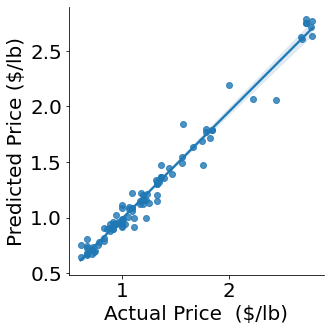

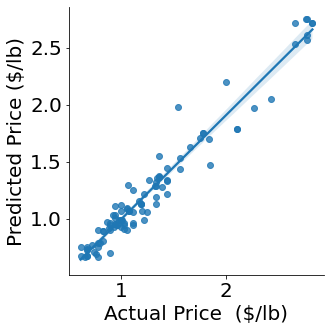

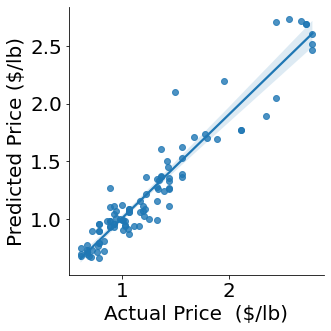

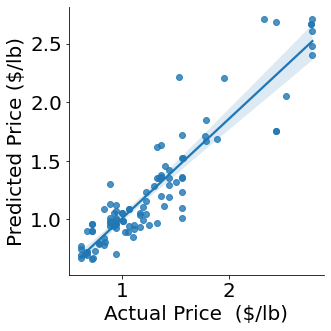

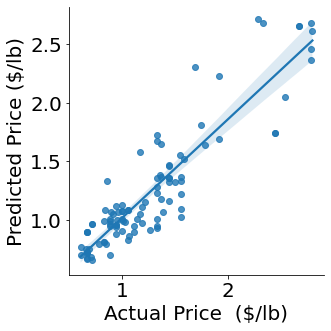

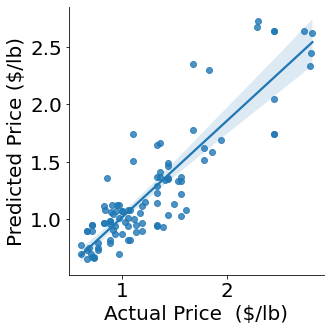

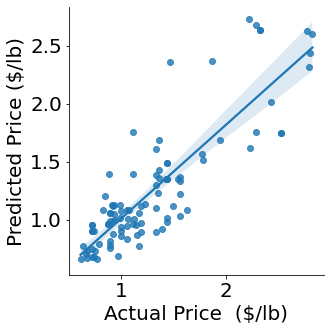

In [38]:
# Main 

import argparse
# from train_teacher_forcing import *
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import easydict

def main(
    epoch: int = 5000, #1000
    k: int = 30, #60
    batch_size: int = 1, #10
    #frequency: int = 50, #100
    training_length = 20, #270
    forecast_window = 8, #30
    train_csv = "MV_train_dataset.csv",
    test_csv = "MV_test_dataset.csv",
    path_to_save_model = "save_model/",
    path_to_save_loss = "save_loss/", 
    path_to_save_predictions = "save_predictions/", 
    device = "cpu"
):

    

    test_dataset = MakeDataset(csv_name = test_csv, root_dir = "Data/", training_length = training_length, forecast_window = forecast_window)
    test_dataloader = DataLoader(test_dataset, batch_size = 1, shuffle=True)

    #best_model = transformer(train_dataloader, epoch, k, path_to_save_model, path_to_save_loss, path_to_save_predictions, device)
    best_model = "best_train_3686.pth"
    inference(path_to_save_predictions, forecast_window, test_dataloader, device, path_to_save_model, best_model)

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    args = parser.parse_args(args=[])
    args = easydict.EasyDict({
    "epoch":5000,  
    "k": 30,
    "batch_size": 1,
    #"frequency": 50,
    "path_to_save_model": "save_model/",
    "path_to_save_loss": "save_loss/",
    "path_to_save_predictions": "save_predictions/",
    "device": "cpu"
    })
    
    #parser = argparse.ArgumentParser()
    #parser.add_argument("--epoch", type=int, default=5) #1000
    #parser.add_argument("--k", type=int, default=60)
    #parser.add_argument("--batch_size", type=int, default=1)
    #parser.add_argument("--frequency", type=int, default=100)
    #parser.add_argument("--path_to_save_model",type=str,default="save_model/")
    #parser.add_argument("--path_to_save_loss",type=str,default="save_loss/")
    #parser.add_argument("--path_to_save_predictions",type=str,default="save_predictions/")
    #parser.add_argument("--device", type=str, default="cpu")
    #args = parser.parse_args()

    main(
        epoch=args.epoch,
        k = args.k,
        batch_size=args.batch_size,
        #frequency=args.frequency,
        path_to_save_model=args.path_to_save_model,
        path_to_save_loss=args.path_to_save_loss,
        path_to_save_predictions=args.path_to_save_predictions,
        device=args.device,
    )



In [11]:
#tensor([0.9740, 0.9195, 0.8319, 0.7977, 0.7183, 0.6132, 0.5445, 0.4769, 0.4438])